In [2]:
import numpy as np
from scipy import stats,fftpack
from tensorflow.keras.utils import to_categorical
from stochastic import diffusion, continuous
from scipy.optimize import curve_fit
import scipy.io

In [3]:
batchsize = 32
T = 100 # this provides another layer of stochasticity to make the network more robust
steps = 1000 # number of steps to generate
initializer = 'he_normal'
f = 32
sigma = 0.0

In [4]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [5]:
def Sub_mixing(x0, n, dt, scales, out=None):
    x0 = np.asarray(x0)
    # generate a sample of n numbers from a normal distribution.
    r = stats.norm.rvs(size=x0.shape + (n,), scale=np.sqrt(dt))
    r = r*scales
    # If `out` was not given, create an output array.
    if out is None:
        out = np.empty(r.shape)
    # Compute Brownian motion by forming the cumulative sum of random samples. 
    np.cumsum(r, axis=-1, out=out)
    # Add the initial condition.
    out += np.expand_dims(x0, axis=-1)
    return out

def Mixing(N=1000,T=50,deltas = [1], rate = .1):
    x = np.empty((2,N+1))
    x[:,0] = 0.0

    jumps = 1
    jumptimes = np.random.rand(jumps)*N
    jumptimes.sort()
    dc = np.empty(jumps+1)
    dc[0] = np.random.choice(deltas)
    for i, element in enumerate(dc[:-1]):
        temp = deltas[:]  # fastest way to copy
        if len(temp) > 1:
            temp.remove(element)
        dc[i+1] = np.random.choice(temp)

    scales = np.ones(N)*dc[0]

    prev = 0
    succ = None

    for index, jump in enumerate(jumptimes):
        if prev <= N:
            scales[prev:int(jump // 1 + 1)] = dc[index]
            if jump + 1 <= N:
                scales[int(jump // 1 + 1)] = dc[index] * (jump % 1) + dc[index+1] * (1 - jump % 1)
        prev = int(jump // 1 + 2)
    if prev <= N:
        scales[prev:] = dc[-1]

    Sub_mixing(x[:,0], N, T/N, scales, out=x[:,1:])

    out1 = x[0]
    out2 = x[1]

    return out1,out2, jumptimes[0]

In [6]:
'''
Generator functions for neural network training per Keras specifications
input for all functions is as follows:
    
input: 
   - batch size
   - steps: total number of steps in trajectory (list) 
   - T: final time (list)
   - sigma: Standard deviation of localization noise (std of a fixed cell/bead)
'''

# Randomly generate trajectories of different diffusion models for training of the 
# classification network
    
def generate(batchsize=32,steps=steps,T=30,sigma=0.1):
    while True:
        # randomly choose a set of trajectory-length and final-time. This is intended
        # to increase variability in simuation conditions.
        T1 = T #np.random.choice(T,size=1).item()
        out = np.zeros([batchsize,steps-1,1])
        label = np.zeros([batchsize,1])
#         weight = np.zeros(batchsize)
        for i in range(batchsize):
            # randomly select diffusion model to simulate for this iteration
            constants = 2
            dcs = np.random.choice([1,10], constants, replace=False)
#             dcs = np.random.uniform(low = 0, high = 20, size = constants)
            x,y,jumptime = Mixing(N=steps,T=T1,deltas= dcs.tolist(), rate = .1) 
            label[i,0] = jumptime
#             weight[i] =  1/stats.poisson.pmf(jumps, mu = .1*T)
            noise = np.sqrt(sigma)*np.random.randn(1,steps)
            x1 = np.reshape(x,[1,len(x)])
            x1 = x1-np.mean(x1)
            x_n = x1[0,:steps]+noise
            dx = np.diff(x_n)
            out[i,:,0] = dx*dx
       
#         label = to_categorical(label)

        yield out,label,[None]


In [7]:
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,BatchNormalization,Conv1D
from tensorflow.keras.layers import Input,GlobalMaxPooling1D,concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint

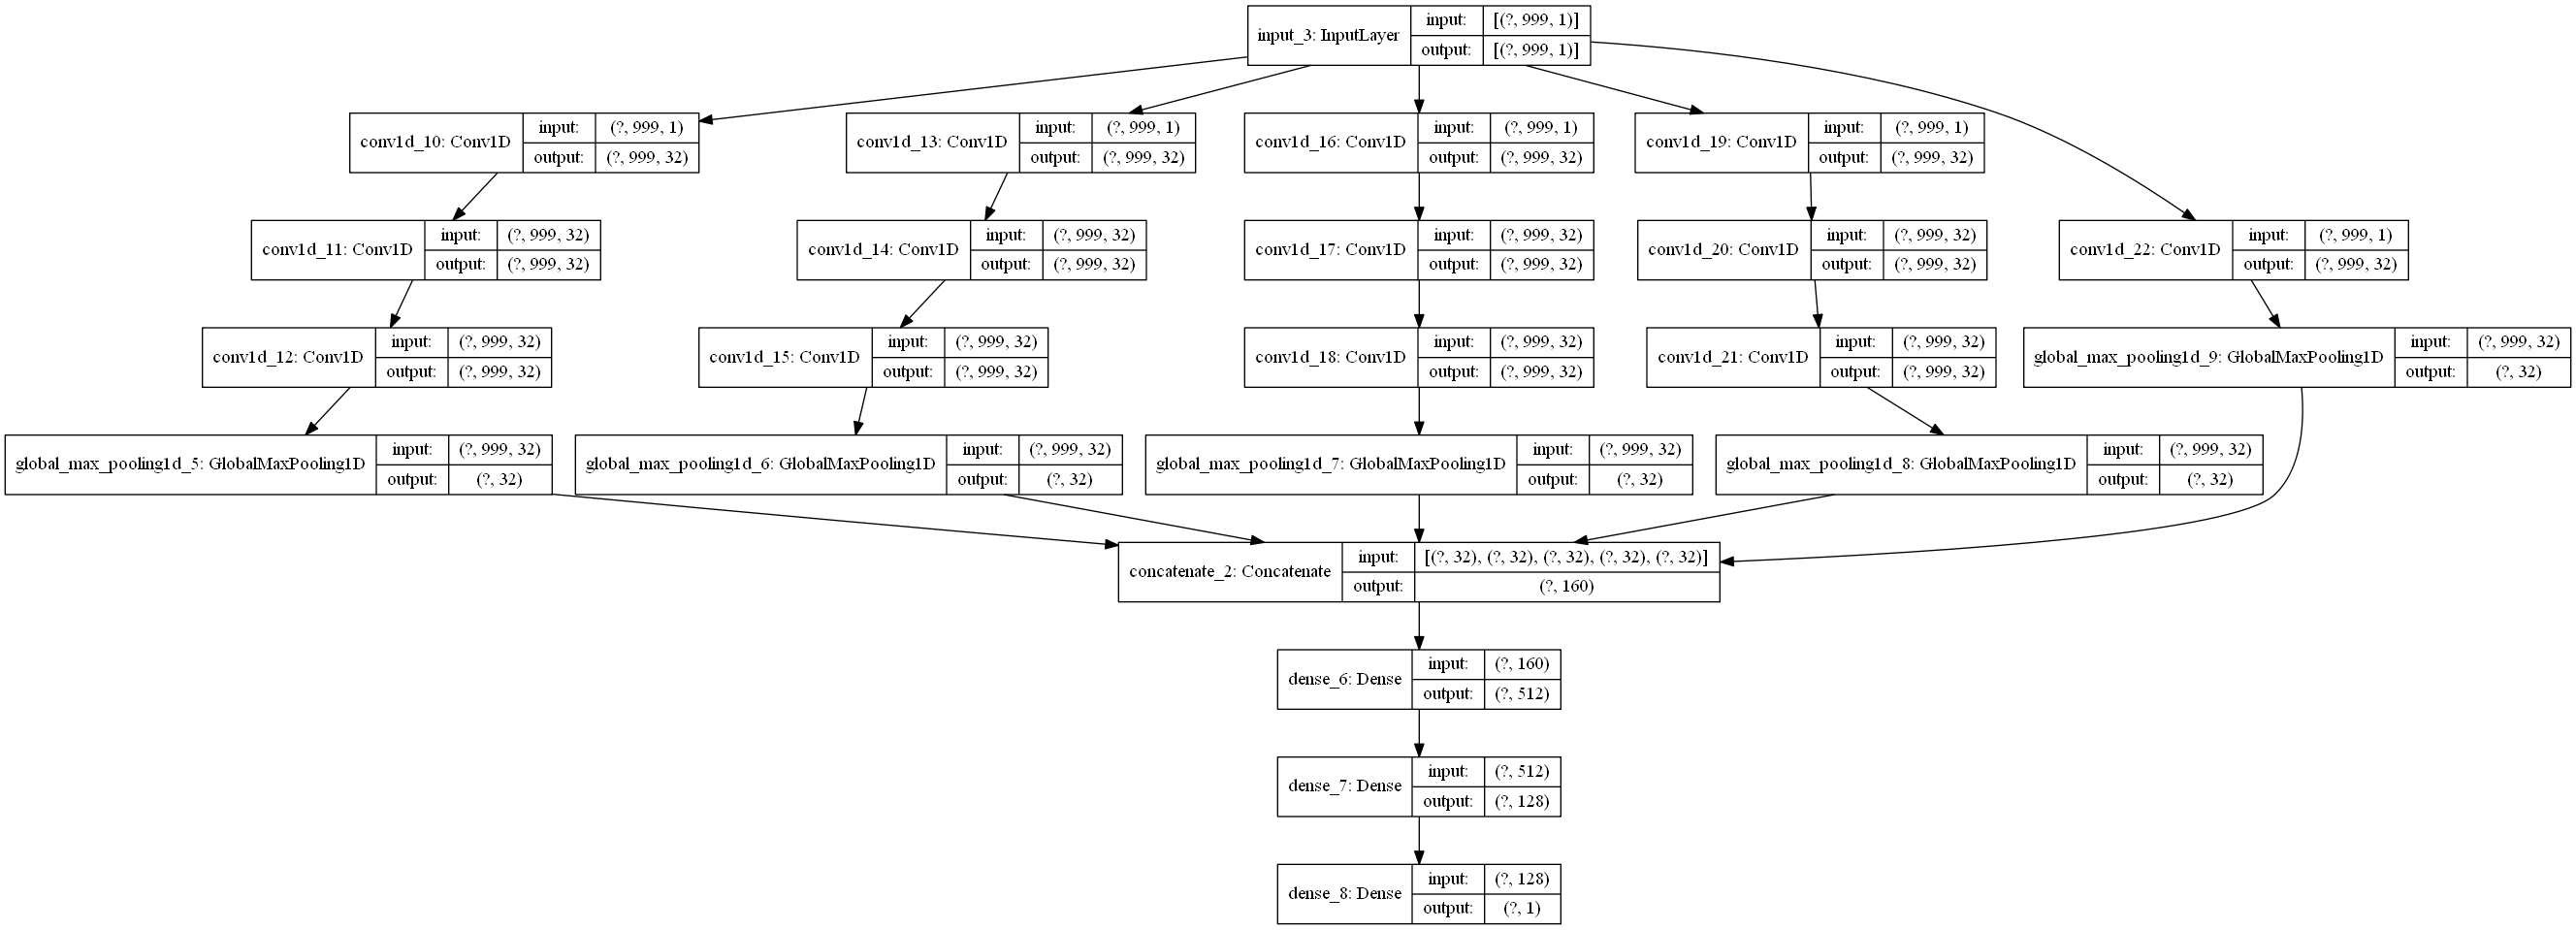

In [62]:
inputs = Input((steps-1,1))

x1 = Conv1D(f,4,padding='causal',activation='relu',kernel_initializer=initializer)(inputs)
x1 = Conv1D(f,4,dilation_rate=2,padding='causal',activation='relu',kernel_initializer=initializer)(x1)
x1 = Conv1D(f,4,dilation_rate=4,padding='causal',activation='relu',kernel_initializer=initializer)(x1)
x1 = GlobalMaxPooling1D()(x1)


x2 = Conv1D(f,2,padding='causal',activation='relu',kernel_initializer=initializer)(inputs)
x2 = Conv1D(f,2,dilation_rate=2,padding='causal',activation='relu',kernel_initializer=initializer)(x2)
x2 = Conv1D(f,2,dilation_rate=4,padding='causal',activation='relu',kernel_initializer=initializer)(x2)
x2 = GlobalMaxPooling1D()(x2)


x3 = Conv1D(f,3,padding='causal',activation='relu',kernel_initializer=initializer)(inputs)
x3 = Conv1D(f,3,dilation_rate=2,padding='causal',activation='relu',kernel_initializer=initializer)(x3)
x3 = Conv1D(f,3,dilation_rate=4,padding='causal',activation='relu',kernel_initializer=initializer)(x3)
x3 = GlobalMaxPooling1D()(x3)


x4 = Conv1D(f,10,padding='causal',activation='relu',kernel_initializer=initializer)(inputs)
x4 = Conv1D(f,10,dilation_rate=4,padding='causal',activation='relu',kernel_initializer=initializer)(x4)
x4 = Conv1D(f,10,dilation_rate=8,padding='causal',activation='relu',kernel_initializer=initializer)(x4)
x4 = GlobalMaxPooling1D()(x4)


x5 = Conv1D(f,20,padding='same',activation='relu',kernel_initializer=initializer)(inputs)
x5 = GlobalMaxPooling1D()(x5)


con = concatenate([x1,x2,x3,x4,x5])
dense = Dense(512,activation='relu')(con)
dense = Dense(128,activation='relu')(dense)
dense2 = Dense(1,activation='relu')(dense)
model = Model(inputs=inputs, outputs=dense2)

optimizer = Adam(lr=1e-5)
model.compile(optimizer=optimizer,loss='MSE',metrics=['MAE'])
keras.utils.plot_model(model, "my_first_model_with_shape_info.png", show_shapes=True)

In [63]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=40,
        verbose=1,
        min_delta=1e-4
    ),
#     ReduceLROnPlateau(
#         monitor='MAPE',
#         factor=0.1,
#         patience=4,
#         verbose=1,
#         min_lr=1e-9
#     ),
    ModelCheckpoint(
        filepath='new_class_model.h5',
        monitor='MAE',
        save_best_only=True,
        mode='min',
        save_weights_only=False
    )
]

In [64]:
gen = generate(batchsize=batchsize,steps=steps,T=T,sigma=sigma)

history = model.fit(gen,
        steps_per_epoch=5,
        epochs=1000,
        callbacks=callbacks,
        validation_data=generate(batchsize=batchsize,steps=steps,T=T,sigma=sigma),
        validation_steps=5)

Train for 5 steps, validate for 5 steps
Epoch 1/1000
5/5 [==============================] - 3s 671ms/step - loss: 351925.7687 - MAE: 522.3187 - val_loss: 338317.3531 - val_MAE: 505.4753
Epoch 2/1000
5/5 [==============================] - 1s 109ms/step - loss: 296182.3531 - MAE: 457.6335 - val_loss: 332843.5750 - val_MAE: 505.1570
Epoch 3/1000
5/5 [==============================] - 0s 87ms/step - loss: 311273.1688 - MAE: 481.6234 - val_loss: 278970.4969 - val_MAE: 446.0600
Epoch 4/1000
5/5 [==============================] - 0s 87ms/step - loss: 300420.4000 - MAE: 460.0618 - val_loss: 313185.8656 - val_MAE: 487.8798
Epoch 5/1000
5/5 [==============================] - 1s 107ms/step - loss: 275278.8000 - MAE: 437.3874 - val_loss: 270833.5750 - val_MAE: 433.2648
Epoch 6/1000
5/5 [==============================] - 0s 87ms/step - loss: 288437.8594 - MAE: 449.1996 - val_loss: 264580.5469 - val_MAE: 425.9010
Epoch 7/1000
5/5 [==============================] - 0s 87ms/step - loss: 281089.3719 - 

In [65]:
gen = generate(batchsize=32,steps=steps,T=T,sigma=sigma)
# next(gen)

In [66]:
model = keras.models.load_model('new_class_model.h5')
model.evaluate(gen, steps = 200)

200/200 [==============================] - 5s 25ms/step - loss: 99916.6585 - MAE: 260.2427


[99916.65845703126, 260.24274]

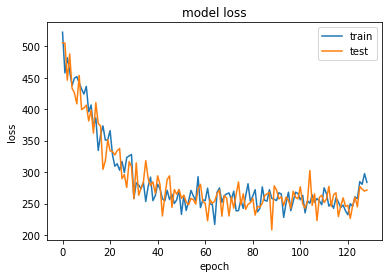

In [67]:
from matplotlib import pyplot as plt

# summarize history for loss
plt.plot(history.history['MAE'])
plt.plot(history.history['val_MAE'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.savefig('onejumprandomtimelearningcurve.pdf')

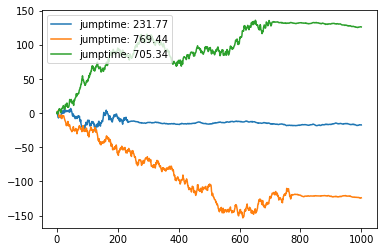

In [68]:
for i in range(3):
    jumplist = []
    test, _ ,jumps = Mixing(deltas = [1,10])
    test = np.squeeze(test)
    plt.plot(test, label = "jumptime: " + "{:.2f}".format(jumps-1))
    
plt.legend(loc='upper left')
plt.savefig('onejumprandomtime.pdf')

In [69]:
test, labels, _ = next(generate(batchsize=500,steps=steps,T=T,sigma=sigma))
labels

array([[666.52277005],
       [582.16109611],
       [309.22326308],
       [793.65863914],
       [984.38286249],
       [660.78681712],
       [603.87677384],
       [454.71724901],
       [395.79906198],
       [390.0270605 ],
       [688.65525204],
       [815.89642352],
       [636.27143695],
       [969.47779572],
       [763.85043927],
       [200.23887295],
       [ 48.8466266 ],
       [602.67654872],
       [537.23088692],
       [320.24388968],
       [891.82119928],
       [ 98.19323299],
       [988.29408602],
       [109.01304778],
       [332.46508306],
       [761.15760561],
       [227.46966044],
       [679.63183764],
       [949.07632671],
       [109.42516819],
       [797.57903046],
       [ 92.91909751],
       [649.90596715],
       [460.15470549],
       [977.73154176],
       [249.01471165],
       [193.00777736],
       [642.86086511],
       [603.66445969],
       [219.66931192],
       [243.91966477],
       [611.84997491],
       [ 31.80178031],
       [ 20

In [70]:
predictions = model.predict(test)

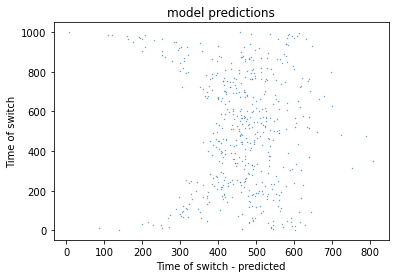

In [71]:
plt.scatter(
    y = labels,
    x = predictions,
    s = .1
)
# plt.legend(loc = 'upper right')
plt.title('model predictions')
plt.ylabel('Time of switch')
plt.xlabel('Time of switch - predicted')
plt.savefig('timeofswitchprediction.pdf')

In [ ]:
np.shape(labels)

In [22]:
model.evaluate(gen, steps = 50)

 1/50 [..............................] - ETA: 8:14

ResourceExhaustedError:  OOM when allocating tensor with shape[500,1,999,32] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/conv1d_4/conv1d-0-0-TransposeNCHWToNHWC-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_distributed_function_14832]

Function call stack:
distributed_function


In [ ]:
model.evaluate(gen, steps = 50)

(array([ 20.,  29.,  94., 363., 331., 124.,  29.,   8.,   1.,   1.]),
 array([  49.176575,  147.9076  ,  246.6386  ,  345.3696  ,  444.10062 ,
         542.83167 ,  641.5626  ,  740.29364 ,  839.02466 ,  937.7557  ,
        1036.4867  ], dtype=float32),
 <BarContainer object of 10 artists>)

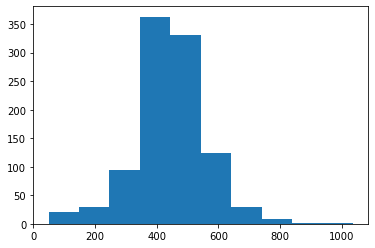

In [90]:
plt.hist(predictions)